## Radiation map

We would like a model to have as inputs the irradiance of the sensors and as outputs the irradiance on a rectangular grid. Let us split the sensors in two groups: inner sensors and outer sensors. Given an initial set, would it be possible to decide the location of new outer sensors to maximize the predicibility of the inner sensors (based on irradiance data)?

In [1]:
import pandas as pd
import numpy as np

In [2]:
DATA_PATH = '/home/SHARED/SOLAR/data/'

In [3]:
# read minute data and location info
df   = pd.read_pickle(DATA_PATH + 'oahu_min_final.pkl')
info = pd.read_pickle(DATA_PATH + 'info.pkl')

In [4]:
info['GHI'] = df.stack().loc['2010-03-19 14:15'].reset_index(level='Datetime').drop(columns='Datetime')

In [18]:
X = info.dropna()[['Latitude', 'Longitude']]
y = info.dropna()['GHI']

In [6]:
grid = X[['Latitude', 'Longitude']].agg([np.min, np.max])

Wrong! Floor for the minimum, but ceil for the maximum!

In [7]:
grid = np.floor(grid*1e3)/1e3

In [116]:
lat = np.arange(grid.loc['amin',  'Latitude'], grid.loc['amax',  'Latitude'], 1e-3)
lon = np.arange(grid.loc['amin', 'Longitude'], grid.loc['amax', 'Longitude'], 1e-3)

In [117]:
xx, yy = np.meshgrid(lon, lat)

In [118]:
X_test = pd.DataFrame({'lon': xx.ravel(), 'lat': yy.ravel()})

In [119]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor()

In [120]:
gpr.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [121]:
y_mean, y_std = gpr.predict(X, return_std=True)

/home/atorres/.local/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [122]:
y_test = pd.concat((X_test, pd.DataFrame(gpr.sample_y(X_test, 50)).agg([np.mean, np.std], axis=1)), axis=1)

In [123]:
y_train = pd.concat((X.reset_index(drop=True), pd.DataFrame({'mean': y_mean, 'std': y_std})), axis=1)

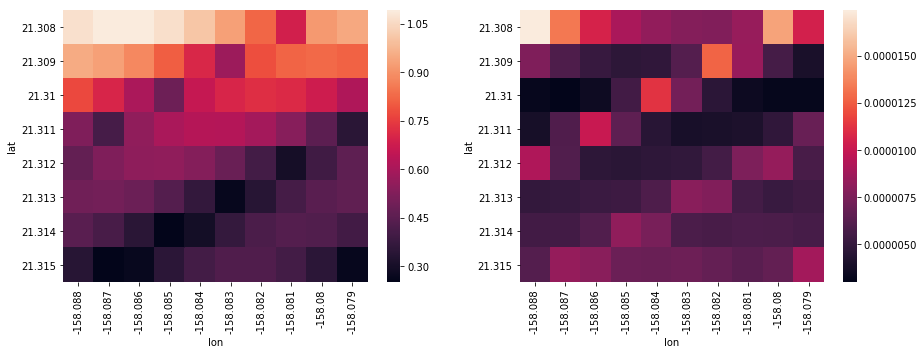

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df1 = y_test.pivot_table(values='mean', columns='lon', index='lat')
sns.heatmap(data=df1,
            xticklabels=df1.columns.values.round(3),
            yticklabels=df1.index.values.round(3),
            ax=ax[0])

df2 = y_test.pivot_table(values='std', columns='lon', index='lat')
sns.heatmap(data=df2,
            xticklabels=df2.columns.values.round(3),
            yticklabels=df2.index.values.round(3),
            ax=ax[1]);

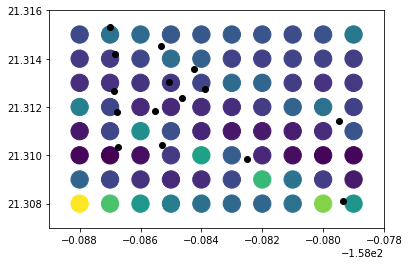

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
ax.scatter(y_test['lon'], y_test['lat'], c=y_test['std'], s=300)
ax.scatter(y_train['Longitude'], y_train['Latitude'], c='black')
ax.set_xlim((y_test['lon'].min()-1e-3, y_test['lon'].max()+1e-3))
ax.set_ylim((y_test['lat'].min()-1e-3, y_test['lat'].max()+1e-3));